In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,9)

In [3]:
refractory = 4e-3 # 4 ms
stop_time = 2000 # seconds
delta_t = 6e-3 # C response delay
delta_tsd = 5e-4 # standard deviation of spike response in C

stim_response = 1e-4 # 0.1 ms
stim_response_std = 1e-5
stim_rate = 30
n_stim = stim_rate * stop_time
hit_rate = .8

stimulus = np.sort(np.random.uniform(0, stop_time, n_stim))

def prune(random, refractory):
    spikes = []
    a = random.copy()
    while len(a) > 1:
        spikes.append(a[0])
        a = a[a - a[0] > refractory]
    return np.array(spikes)

# response to stimulus
stimulus_spikes = norm.rvs(loc=stimulus + stim_response, scale=stim_response_std)

A_spikes = np.sort(stimulus_spikes[np.random.randint(0, n_stim, int(n_stim * hit_rate))])
A_spikes = prune(A_spikes, refractory)

B_spikes = np.sort(stimulus_spikes[np.random.randint(0, n_stim, int(n_stim * hit_rate))])
B_spikes = prune(B_spikes, refractory)

C_spikes = norm.rvs(loc=A_spikes + delta_t, scale=delta_tsd)
C_spikes = prune(C_spikes, refractory)

In [4]:
assert all(np.diff(A_spikes) >= refractory)
assert all(np.diff(B_spikes) >= refractory)
assert all(np.diff(C_spikes) >= refractory)

(0, 0.2)

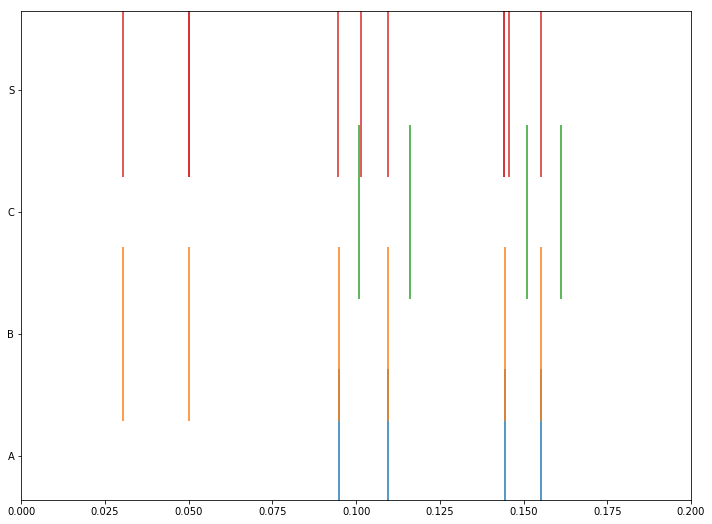

In [5]:
plt.figure()
s = 30000
N = 20
plt.scatter(A_spikes[:N], 1.*np.ones(N), marker='|', s=s, label='A')
plt.scatter(B_spikes[:N], 2.*np.ones(N), marker='|', s=s, label='B')
plt.scatter(C_spikes[:N], 3.*np.ones(N), marker='|', s=s, label='C')
plt.scatter(stimulus[:N], 4.*np.ones(N), marker='|', s=s, label='S')
plt.yticks([1, 2, 3, 4],['A', 'B', 'C', 'S'])
plt.xlim(0,2e-1)

In [7]:
# rate
len(A_spikes) / stop_time, len(B_spikes) / stop_time, len(C_spikes) / stop_time

(15.4855, 15.5525, 15.406)

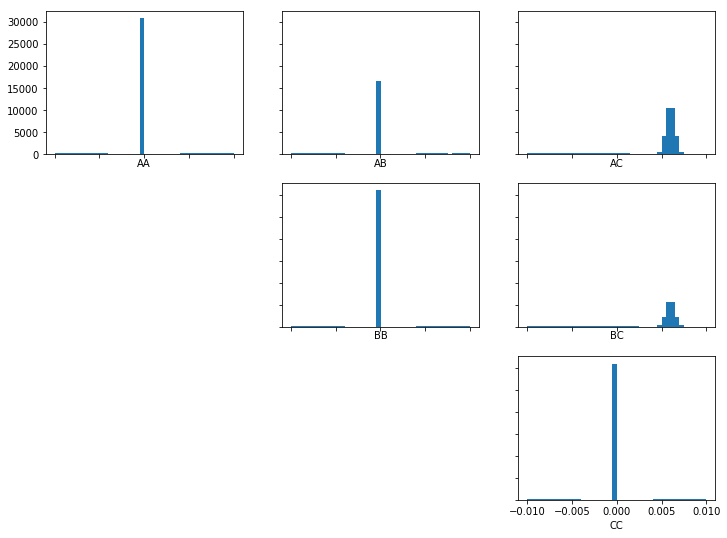

In [8]:
def xcorr(t1, t2, binsize=1e-3, limit=1):
    bins = np.arange(-limit, limit + binsize, binsize)

    # Determine the indexes into `t2` that are relevant for each spike in `t1`
    ii2 = np.searchsorted(t2, t1 - limit)
    jj2 = np.searchsorted(t2, t1 + limit)

    # Concatenate the recentered spike times into a big array
    # We have excluded spikes outside of the histogram range to limit
    # memory use here.
    big = np.concatenate([t2[i:j] - t for t, i, j in zip(t1, ii2, jj2)])

    # Actually do the histogram. Note that calls to np.histogram are
    # expensive because it does not assume sorted data.
    count, bins = np.histogram(big, bins=bins)
    
    return bins[1:], count

binsize=5e-4
limit=1e-2
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
axs = axs.ravel()
cnt = 0
for s1, l1 in zip([A_spikes, B_spikes, C_spikes], ['A', 'B', 'C']):
    for s2, l2 in zip([A_spikes, B_spikes, C_spikes], ['A', 'B', 'C']):
        axs[cnt].bar(*xcorr(s1, s2, binsize=binsize, limit=limit), width=-binsize, align='edge')
        axs[cnt].set_xlabel(l1 + l2)
        cnt += 1
        if cnt in [3,6,7]:
            axs[cnt].remove()
# plt.ylim(0,200)

<BarContainer object of 40 artists>

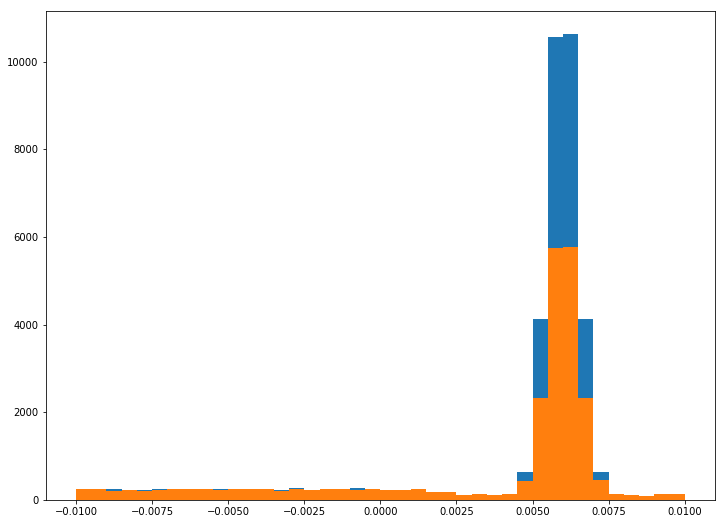

In [9]:
binsize=5e-4
limit=1e-2
plt.bar(*xcorr(A_spikes, C_spikes, binsize=binsize, limit=limit), width=-binsize, align='edge')
plt.bar(*xcorr(B_spikes, C_spikes, binsize=binsize, limit=limit), width=-binsize, align='edge')

In [10]:
sigma = 5e-4 # 0.1 ms
bins = np.arange(0, stop_time + sigma, sigma)

int(refractory/sigma), int(refractory/sigma) * refractory

(8, 0.032)

In [11]:
A = []
for i in range(0, int(refractory / sigma)):
    cnt, _ = np.histogram(A_spikes + sigma * i, bins=bins)
    A.append(cnt)
A = np.array(A)

B = []
for i in range(0, int(refractory / sigma)):
    cnt, _ = np.histogram(B_spikes + sigma * i, bins=bins)
    B.append(cnt)
B = np.array(B)

(0, 0.3)

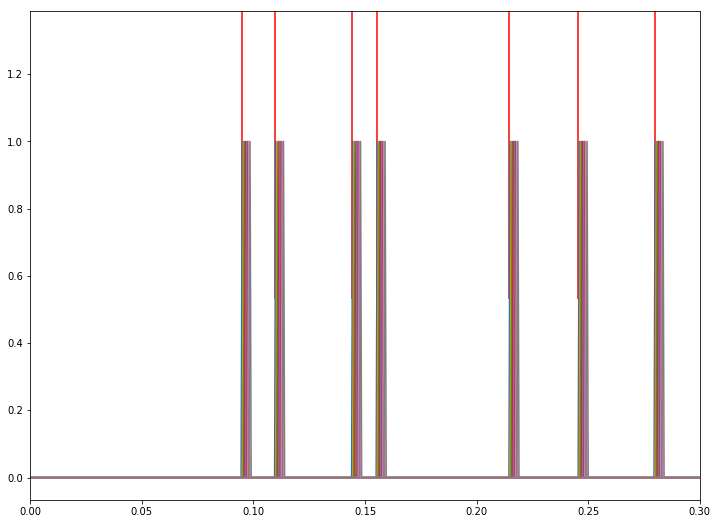

In [14]:
plt.scatter(A_spikes, 1.*np.ones(A_spikes.shape[0]), marker='|', s=100000, color='r')
for a in A:
    plt.plot(bins[1:], a)
plt.xlim(0, 0.3)

In [15]:
X_A = sm.add_constant(A[1:].T)
model = sm.Logit(A[0], X_A)
results_A = model.fit()

         Current function value: 0.044917
         Iterations: 35


/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [16]:
X_B = sm.add_constant(B[1:].T)
model = sm.Logit(B[0], X_B)
results_B = model.fit()

         Current function value: 0.045076
         Iterations: 35


/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(10, 10.5)

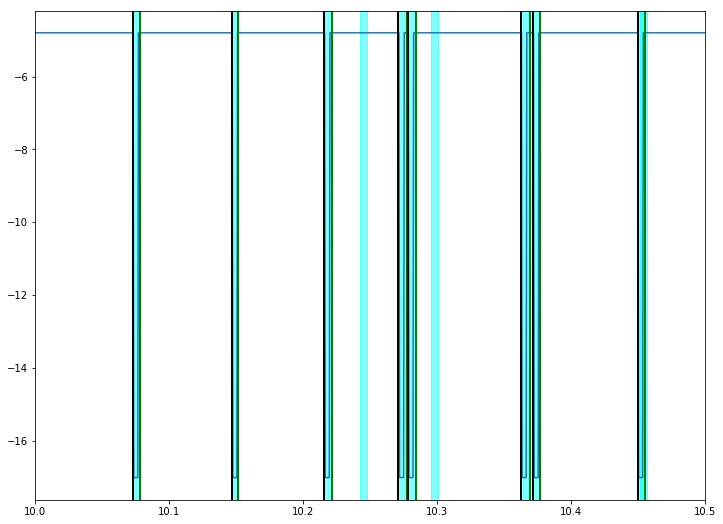

In [17]:
xlim = [10, 10.5]
plt.plot(bins[1:], results_A.fittedvalues)
for a, b, c, s in zip(A_spikes, B_spikes, C_spikes, stimulus):
    if a > xlim[0] and a < xlim[1]:
        plt.axvline(x=a, c='black', lw=2)
    if b > xlim[0] and b < xlim[1]:
        plt.axvline(x=b, c='red', lw=2)
    if c > xlim[0] and c < xlim[1]:
        plt.axvline(x=c, c='green', lw=2)
    if s > xlim[0] and s < xlim[1]:
        plt.axvspan(s, s + 5e-3, alpha=.5, color='cyan')

plt.xlim(xlim)

In [18]:
C, _ = np.histogram(C_spikes - delta_t + stim_response, bins=bins)

(0, 0.1)

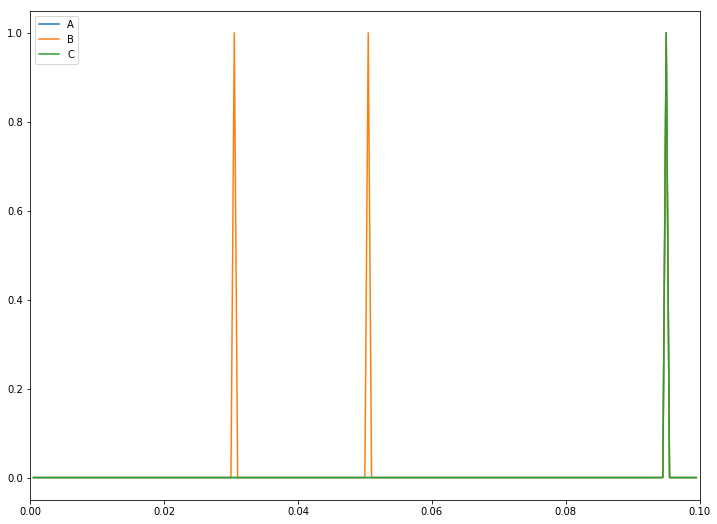

In [19]:
xlim = [0, .1]
mask = (bins[1:] > xlim[0]) & (bins[1:] < xlim[1])
plt.plot(bins[1:][mask], A[0][mask], label='A')
plt.plot(bins[1:][mask], B[0][mask], label='B')
plt.plot(bins[1:][mask], C[mask], label='C')
plt.legend()
plt.xlim(xlim)

In [20]:
X_AC = sm.add_constant(results_A.fittedvalues)
model = sm.OLS(C, X_AC)
results_AC = model.fit()

In [22]:
X_BC = sm.add_constant(results_B.fittedvalues)
model = sm.OLS(C, X_BC)
results_BC = model.fit()

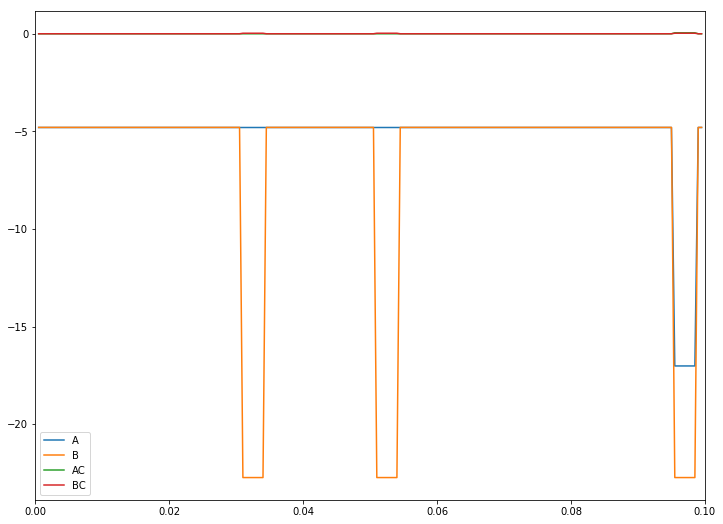

In [24]:
xlim = [0, .1]
mask = (bins[1:] > xlim[0]) & (bins[1:] < xlim[1])
plt.plot(bins[1:][mask], results_A.fittedvalues[mask], label='A')
plt.plot(bins[1:][mask], results_B.fittedvalues[mask], label='B')
plt.plot(bins[1:][mask], results_AC.fittedvalues[mask], label='AC')
plt.plot(bins[1:][mask], results_BC.fittedvalues[mask], label='BC')
plt.xlim(xlim)
plt.legend()

In [25]:
results_AC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                 6.857e+04
Date:                Tue, 21 May 2019   Prob (F-statistic):               0.00
Time:                        15:47:24   Log-Likelihood:             4.1060e+06
No. Observations:             4000000   AIC:                        -8.212e+06
Df Residuals:                 3999998   BIC:                        -8.212e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0147   9.59e-05   -153.258      0.000      -0.015      -0.015
x1            -0.0041   1.57e-05   -261.857      0.000      -0.004      -0.004
==============================================================================
Omnibus:                  6437501.770   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2521618308.134
Skew:                          10.986   Prob(JB):                         0.00
Kurtosis:                     124.024   Cond. No.                         13.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
results_BC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                 1.898e+04
Date:                Tue, 21 May 2019   Prob (F-statistic):               0.00
Time:                        15:47:27   Log-Likelihood:             4.0815e+06
No. Observations:             4000000   AIC:                        -8.163e+06
Df Residuals:                 3999998   BIC:                        -8.163e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008   7.56e-05    -10.733      0.000      -0.001      -0.001
x1            -0.0015   1.07e-05   -137.754      0.000      -0.001      -0.001
==============================================================================
Omnibus:                  6496402.974   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2634503601.944
Skew:                          11.184   Prob(JB):                         0.00
Kurtosis:                     126.720   Cond. No.                         12.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
def calculate_response(stim_times, source, target, winsize, latency):
    src = np.searchsorted
    result = {
        'stim_response': (
            # stim response
            src(source, stim_times, 'left') <
            src(source, stim_times + winsize, 'right')),
        'syn_response': (
            # stim synaptic response
            src(target, stim_times + latency, 'left') <
            src(target, stim_times + latency + winsize, 'right'))
    }
    return result

def wald(stim_times, source, target, winsize, latency):
    """The IV estimator used in the paper"""
    responses = calculate_response(
        stim_times, source, target, winsize, latency)
    z0 = responses['stim_response'] == 0
    z1 = z0 == False

    y1 = responses['syn_response'][z1]
    y0 = responses['syn_response'][z0]
    return y1.mean() - y0.mean()

In [34]:
wald(stimulus, A_spikes, C_spikes, delta_tsd * 4, delta_t - delta_tsd * 2)

0.8997915424451549

In [35]:
wald(stimulus, B_spikes, C_spikes, delta_tsd * 4, delta_t - delta_tsd * 2)

0.0308698215291226